In [ ]:
!pip install transformers
!pip install tensorflow-text

     |████████████████████████████████| 3.5 MB 5.2 MB/s 
     |████████████████████████████████| 895 kB 39.9 MB/s 
     |████████████████████████████████| 6.5 MB 32.7 MB/s 
     |████████████████████████████████| 596 kB 41.3 MB/s 
     |████████████████████████████████| 67 kB 5.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 4.9 MB 4.5 MB/s 
     |████████████████████████████████| 462 kB 33.1 MB/s 


# Multi-label classification task
  toxic, severe_toxic, obscene, threat, insult, identity_hate

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from sklearn.metrics import classification_report,  multilabel_confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split

from transformers import create_optimizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
#df_train = pd.read_csv('../data/train_cleaned.zip', compression='zip')
df_train = pd.read_csv('/content/drive/My Drive/train_cleaned.zip', compression='zip', engine='python')
df_train.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxicity,clean_text,tokenized,tokenized_no_stopwords,tokenized_stemmed,tokenized_pos,tokenized_lemmatized,tokenized_lemmatized_pos,tokenized_bigram
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,explanation why the edits made under my userna...,"['explanation', 'why', 'the', 'edits', 'made',...","['explanation', 'edits', 'made', 'username', '...","['explan', 'edit', 'made', 'usernam', 'hardcor...","[('explanation', 'NN'), ('edits', 'NNS'), ('ma...","['explanation', 'edits', 'made', 'username', '...","['explanation', 'edits', 'make', 'username', '...","[('explanation', 'edits'), ('edits', 'made'), ..."


In [ ]:
df_test = pd.read_csv('/content/drive/My Drive/test_cleaned.zip', compression='zip', engine='python')
df_test.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxicity,clean_text,tokenized,tokenized_no_stopwords,tokenized_stemmed,tokenized_pos,tokenized_lemmatized,tokenized_lemmatized_pos,tokenized_bigram
0,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0,0,thank you for understanding i think very highl...,"['thank', 'you', 'for', 'understanding', 'i', ...","['thank', 'understanding', 'think', 'highly', ...","['thank', 'understand', 'think', 'highli', 'wo...","[('thank', 'NN'), ('understanding', 'VBG'), ('...","['thank', 'understanding', 'think', 'highly', ...","['thank', 'understand', 'think', 'highly', 'wo...","[('thank', 'understanding'), ('understanding',..."


In [ ]:
df_train['clean_text'] = df_train['clean_text'].apply(lambda x: str(x))
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: str(x))

In [ ]:
#https://tfhub.dev/google/collections/bert/1

#Input Layer
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

#Preprocessing Layer
preprocessing_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)

#Encoder Layer
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/2", trainable=True, name='smallBERT_encoder')
outputs = encoder(encoder_inputs)

#Classification Layers
net = outputs['pooled_output']
net = tf.keras.layers.Dropout(0.5)(net)
net = tf.keras.layers.Dense(768, activation='relu')(net)
net = tf.keras.layers.Dense(6, activation='sigmoid', name='classifier')(net)

model = tf.keras.Model(inputs=[text_input], outputs=[net])

In [ ]:
text_test = [df_train.clean_text[0]]
text_preprocessed = preprocessing_layer(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"]}')
print(f'Input Mask : {text_preprocessed["input_mask"]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [[  101  7526  2339  1996 10086  2015  2081  2104  2026  5310 18442 13076
  12392  2050  5470  2020 16407  2027  2020  2025  3158  9305 22556  2074
   8503  2006  2070  3806  2044  1045  5444  2012  2047  2259 14421  6904
   2278  1998  3531  2079  2025  6366  1996 23561  2013  1996  2831  3931
   2144  1045  2572  3394  2085   102     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]]
Input Mask : [[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 

In [ ]:
bert_results = encoder(text_preprocessed)

print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"]}')

Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[[ 0.9998182   0.36561713 -0.06045711  0.9998913   0.55053735 -0.51977396
   0.03203234 -0.99686605 -0.04788584  0.07592133 -0.08190849 -0.99396735
  -0.4589937   0.5932564   0.05001172  0.38892004 -0.42809942  0.11761143
   0.41652572  0.35130024 -0.9869586   0.91411865 -0.9109081   0.9934927
  -0.9423563  -0.31576657  0.22837617 -0.38757426 -0.01363051  0.14295742
   0.37431142 -0.02334367 -0.16945265 -0.4603301  -0.9999556  -0.06813609
  -0.10186746  0.01416299 -0.10222375 -0.9383178  -0.24377531 -0.9995583
   0.81198335 -0.28889677 -0.43811494 -0.42335576 -0.5356884   0.6370769
   0.29279906  0.8053607  -0.63071495  0.51290536 -0.3375983   0.6425824
   0.41347033  0.32926357 -0.77722913 -0.9800702  -0.40091726 -0.9944658
  -0.9995405  -0.9835867  -0.95790476 -0.07734024  0.9889927   0.89004374
  -0.3642538   0.38553897 -0.1116308   0.9994012   0.03150657  0.9635238
  -0.99123955 -0.2977037   0.49742872  0.93888766 -0.46160275  0.5

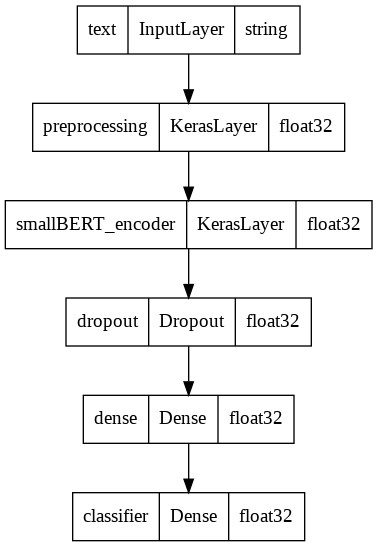

In [ ]:
tf.keras.utils.plot_model(model, show_dtype=True)

In [ ]:
X = df_train.clean_text
y = df_train[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape

((127656,), (31915,))

In [ ]:
X_test = df_test.clean_text
y_test = df_test[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
X_test.shape

(63978,)

In [ ]:
batch_size = 32
epochs  = 2
batches_per_epoch = len(X_train) // batch_size
total_train_steps = int(batches_per_epoch * epochs)

optimizer, schedule = create_optimizer(
    init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps
)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics='acc')

In [ ]:
batches_per_epoch, total_train_steps

(3989, 7978)

In [ ]:
history = model.fit(X_train, y_train,
                       validation_data=(X_val, y_val), 
                       epochs=epochs)

Epoch 1/2
3990/3990 [==============================] - 2836s 709ms/step - loss: 0.0516 - acc: 0.8087 - val_loss: 0.0405 - val_acc: 0.9940
Epoch 2/2
3990/3990 [==============================] - 2826s 708ms/step - loss: 0.0372 - acc: 0.8914 - val_loss: 0.0392 - val_acc: 0.9930


In [ ]:
history.history

{'acc': [0.8087359666824341, 0.891411304473877],
 'loss': [0.05162466689944267, 0.037166718393564224],
 'val_acc': [0.993984043598175, 0.9930126667022705],
 'val_loss': [0.0405004657804966, 0.039248667657375336]}

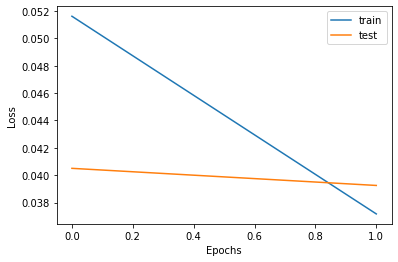

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

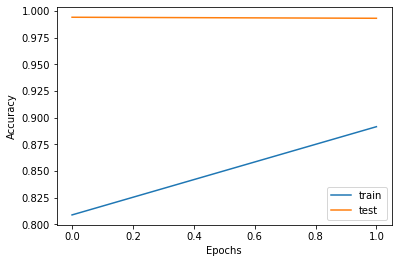

In [ ]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(X_test)
y_pred = np.round(predictions)

In [ ]:
print(classification_report(y_test, y_pred, target_names=['toxic','severe_toxic','obscene','threat','insult','identity_hate']))

               precision    recall  f1-score   support

        toxic       0.52      0.91      0.66      6090
 severe_toxic       0.36      0.56      0.44       367
      obscene       0.59      0.81      0.69      3691
       threat       0.46      0.52      0.49       211
       insult       0.62      0.78      0.69      3427
identity_hate       0.62      0.64      0.63       712

    micro avg       0.56      0.83      0.67     14498
    macro avg       0.53      0.70      0.60     14498
 weighted avg       0.56      0.83      0.67     14498
  samples avg       0.08      0.08      0.08     14498



In [ ]:
multilabel_confusion_matrix(y_test, y_pred)

array([[[52765,  5123],
        [  519,  5571]],

       [[63252,   359],
        [  163,   204]],

       [[58226,  2061],
        [  687,  3004]],

       [[63639,   128],
        [  101,   110]],

       [[58899,  1652],
        [  737,  2690]],

       [[62993,   273],
        [  259,   453]]])

In [ ]:
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')

Accuracy score: 0.866672918815843


In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_test.values[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.values.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
print(roc_auc["micro"])

0.9845106365428627


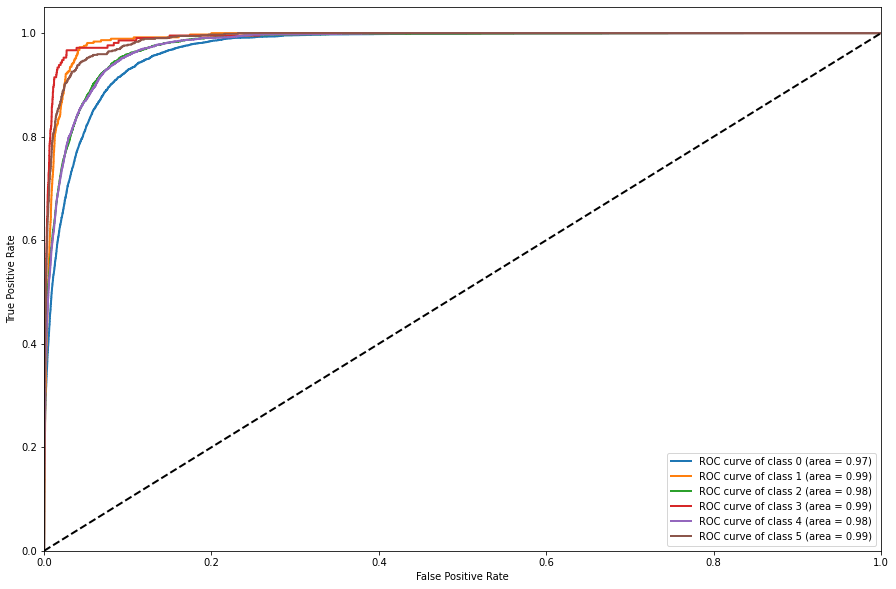

In [ ]:
plt.figure(figsize=(15,10))
for i in range(6):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()